<a href="https://colab.research.google.com/github/antoinebossan1/Codes-for-Kaggle-Competitions/blob/main/Comparison-of-ResNet-18-and-LeNet-5-Models-for-MNIST-Image-Classification/Comparison_ResNet-18_LeNet-5%20Models_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim

#Charging data using kaggle API

In [2]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c digit-recognizer
!unzip digit-recognizer.zip

 85% 13.0M/15.3M [00:01<00:00, 16.7MB/s]
100% 15.3M/15.3M [00:01<00:00, 12.1MB/s]
Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
data = pd.read_csv("train.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Displaying the images before transformation

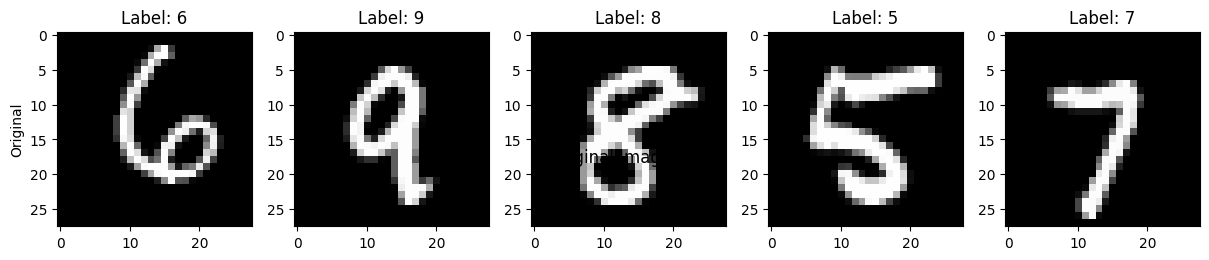

In [5]:

fig, axes = plt.subplots(1, 5, figsize=(12, 6))

for i in range(5):
    index = random.randint(0, len(data))
    img_data = data.iloc[index, 1:].values.reshape(28, 28)
    ax = axes[i]
    ax.imshow(img_data, cmap='gray')
    ax.set_title(f"Label: {data.iloc[index, 0]}")

plt.tight_layout()
fig.subplots_adjust(top=2) 
fig.suptitle("Original Images")
axes[0].set_ylabel("Original")
plt.show()


# Displaying the images after transformation

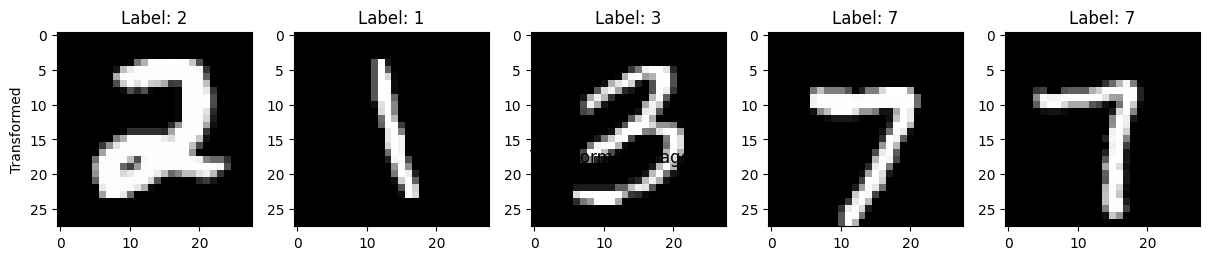

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),    # Convert the input image to a PyTorch Tensor
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Create a 3-channel image for the ResNet18 model
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the image 
])

fig, axes = plt.subplots(1, 5, figsize=(12, 6))

for i in range(5):
    index = random.randint(0, len(data))
    img_data = data.iloc[index, 1:].values.reshape(28, 28)

    img_data = data.iloc[index, 1:].values.astype(np.float32).reshape(28, 28)
    transformed_img_data = transform(img_data).numpy().transpose(1, 2, 0)[:,:,0]
    ax = axes[i]
    ax.imshow(transformed_img_data, cmap='gray')
    ax.set_title(f"Label: {data.iloc[index, 0]}")

plt.tight_layout()
fig.subplots_adjust(top=2)  
fig.suptitle("Transformed Images")
axes[0].set_ylabel("Transformed")
plt.show()

#Defining MNIST Dataset Class.

In [7]:
class MNISTDataset(Dataset):
    def __init__(self, data, transform=None, mode="train"):
        self.data = data
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == "train": # If in train mode, get both image and label
            image = self.data.iloc[index, 1:].values.astype(np.float32).reshape(28, 28)
            label = self.data.iloc[index, 0]
        else:  # If not in train mode, get only the image and set the label to -1
            image = self.data.iloc[index].values.astype(np.float32).reshape(28, 28)
            label = -1

        if self.transform:
            image = self.transform(image)

        return image, label

#Creating Training and Validation Data Loaders

In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=0)

train_dataset = MNISTDataset(train_data, transform)
val_dataset = MNISTDataset(val_data, transform)

# Shuffle the train loader to provide random batches during training, while keeping the validation loader in its original order
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

# Implementing LeNet5
This implementation is based on the code found in the following GitHub repository: https://github.com/gradient-ai/LeNet5-Tutorial


In [9]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


#Creating functions to train and compare the models

In [10]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)  # Pass the inputs through the model to get the output predictions
        _, preds = torch.max(outputs, 1)  # Get the class with the highest predicted probability
        loss = criterion(outputs, labels)  # Calculate the loss between the predicted output and the true labels

        loss.backward()  # Perform backpropagation to calculate gradients
        optimizer.step()  # Update the model parameters using the calculated gradients

        running_loss += loss.item() * inputs.size(0)  # Accumulate the total loss
        running_corrects += torch.sum(preds == labels.data)  # Accumulate the total number of correct predictions

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [11]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()     # Set the model to evaluation mode, which turns off dropout and batch normalization layers

    # Initialize variables to keep track of the running loss and the number of correct predictions
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():     # Turn off gradient calculations
        # Iterate over the dataset using the provided dataloader
        for inputs, labels in dataloader:
            # Move the input and target tensors to the specified device (CPU or GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # Compute the model's output for the given inputs

            _, preds = torch.max(outputs, 1) # Find the predicted class 

            # Compute the loss between the model's prediction and the target labels
            loss = criterion(outputs, labels)

            # Accumulate the loss and the number of correct predictions for the batch
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    # Compute the average loss and accuracy for the entire dataset
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc


# Training and comparing the models

In [12]:
def training(model, train_loader, val_loader, epochs, criterion, optimizer, device):
    best_val_acc = 0.0
    best_model_wts = model.state_dict()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        # Train the model for one epoch and obtain the training loss and accuracy
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        # Evaluate the model on the validation set and obtain the validation loss and accuracy
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        # Update the best model weights if the current validation accuracy is higher than the previous best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()

        # Append the current epoch's losses and accuracies to the history lists
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc.cpu().numpy())
        val_acc_history.append(val_acc.cpu().numpy())


    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

num_epochs = 10


models = {
    "LeNet5": LeNet5(num_classes=10),
    "resnet18": resnet18(num_classes=10)
}

results = {}

for name, model in models.items():
    print(f"Training {name}")

    # Move the model to the specified device
    model = model.to(device)
    # Set the loss function and optimizer for the model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model using the training function defined earlier
    model, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = training(
        model, train_loader, val_loader, num_epochs, criterion, optimizer, device
    )

    # Store the trained model and the history of losses and accuracies in the results dictionary
    results[name] = {
        "model": model,
        "train_loss": train_loss_hist,
        "val_loss": val_loss_hist,
        "train_acc": train_acc_hist,
        "val_acc": val_acc_hist
    }

    print(f"{name} training completed.")


Training LeNet5
LeNet5 training completed.
Training resnet18
resnet18 training completed.


# Plot confusion matrix and F1 score



In [13]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import itertools
    # Calculate accuracy and misclassification rate
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:     # Normalize the confusion matrix
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    # Add the individual cell values as text on the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



def compute_metrics(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():       # Turn off gradient calculations
        for inputs, labels in dataloader:    # Move the input and target tensors to the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute the confusion matrix and the F1-score
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    return cm, f1


LeNet5 Confusion Matrix:


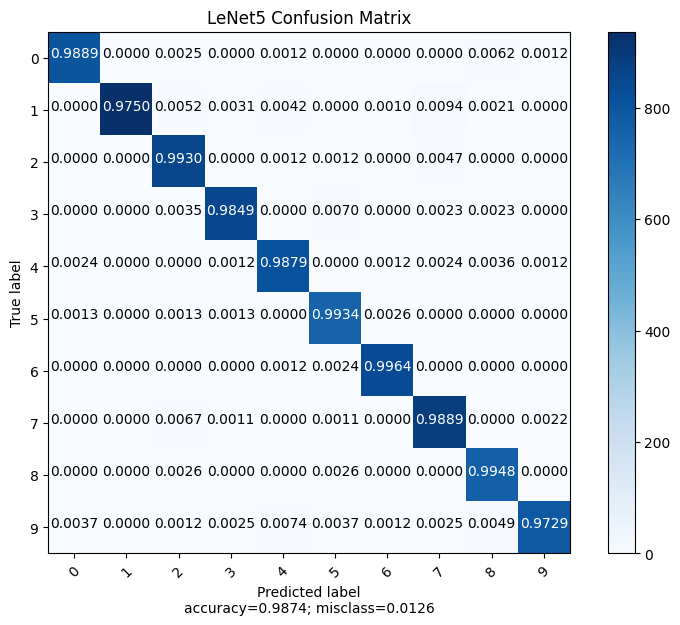

LeNet5 F1 Score: 0.9874
resnet18 Confusion Matrix:


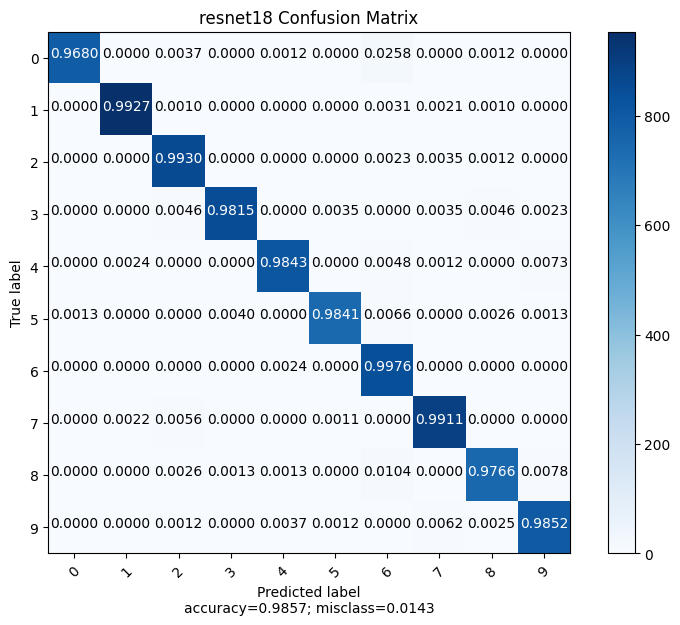

resnet18 F1 Score: 0.9857


In [14]:
for name, result in results.items():
    model = result["model"]
    cm, f1 = compute_metrics(model, val_loader, device)

    print(f"{name} Confusion Matrix:")
    plot_confusion_matrix(cm, list(range(10)), title=f"{name} Confusion Matrix")

    print(f"{name} F1 Score: {f1:.4f}")

# Plot the training loss and accuracy


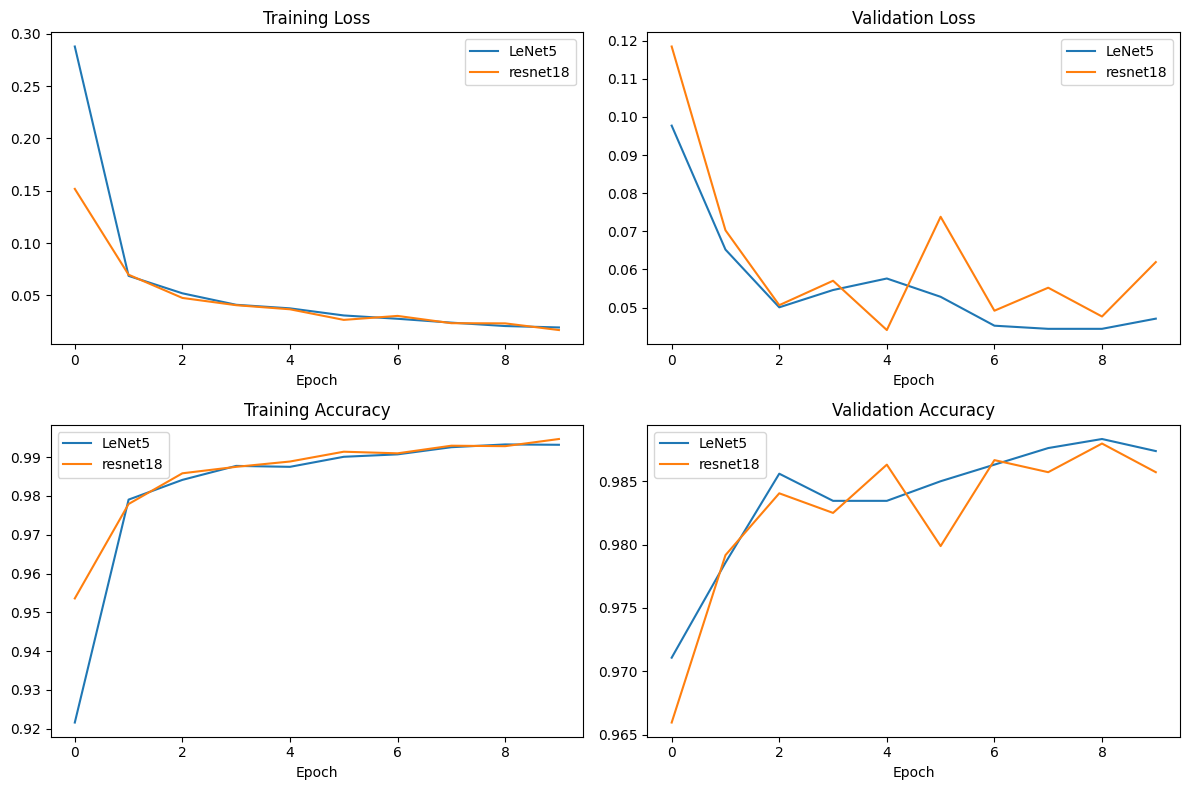

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for name, result in results.items():
    axes[0, 0].plot(result["train_loss"], label=name)
    axes[0, 1].plot(result["val_loss"], label=name)
    axes[1, 0].plot(result["train_acc"], label=name)
    axes[1, 1].plot(result["val_acc"], label=name)

axes[0, 0].set_title("Training Loss")
axes[0, 1].set_title("Validation Loss")
axes[1, 0].set_title("Training Accuracy")
axes[1, 1].set_title("Validation Accuracy")

for ax in axes.flatten():
    ax.legend()
    ax.set_xlabel("Epoch")

plt.tight_layout()
plt.show()



# Making Predictions

In [16]:
test_data = pd.read_csv("test.csv")

test_dataset = MNISTDataset(test_data, transform, mode="test")
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

for name, result in results.items():
    model = result["model"]
    predictions = []

    with torch.no_grad():
        for inputs, _ in test_loader:
            # Move the input data to the specified device
            inputs = inputs.to(device)
            # Get the model's output for the input data
            outputs = model(inputs)
            # Find the class with the highest probability (predicted class)
            _, preds = torch.max(outputs, 1)
            # Add the predicted classes to the predictions list
            predictions.extend(preds.cpu().numpy())

    submission = pd.DataFrame({"ImageId": list(range(1, len(predictions) + 1)), "Label": predictions})
    submission.to_csv(f"{name}_submission.csv", index=False)

    print(f"Created {name}_submission.csv")


Created LeNet5_submission.csv
Created resnet18_submission.csv


In [17]:
!kaggle competitions submit -c digit-recognizer -f resnet18_submission.csv -m "ResNet18 Submission"
!kaggle competitions submit -c digit-recognizer -f LeNet5_submission.csv -m "LeNet5 Submission"

100% 208k/208k [00:02<00:00, 95.1kB/s]
100% 208k/208k [00:02<00:00, 96.6kB/s]
Successfully submitted to Digit Recognizer